# Anomaly Detection with the PyOD (Python Outlier Detector) Package

## Adapted from this Towards Data Science [blog post](https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9). For more details, read the [PyOD Documentation](https://pyod.readthedocs.io/en/latest/pyod.html) or check out the associated [GitHub repo](https://github.com/yzhao062/pyod).

### Set up the exercise

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 2.1MB 8.6MB/s 
  Created wheel for pyod: filename=pyod-0.8.3-cp36-none-any.whl size=110349 sha256=29dc338f48331e75d77029893e2df9f263f9ea1d34bb2596615feff39573196a
  Stored in directory: /root/.cache/pip/wheels/29/46/95/86facd235cce1d58ae6747ab1aea2b3742564325a66a60863a
  Created wheel for combo: filename=combo-0.1.1-cp36-none-any.whl size=42113 sha256=cad1c71f9183962bdd63c60ae4555494b7a913e8427738bcf2afed179717bf79
  Stored in directory: /root/.cache/pip/wheels/55/ec/e5/a2331372c676c467e70c6646e646edf6997d5c4905b8c0f5e6
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167158 sha256=8f7213154d326205fdf08132b4d2ce7318fb7bb372503dc8c954dd62fc49be61
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


/usr/local/lib/python3.6/dist-packages/pyod/utils/data.py:190: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


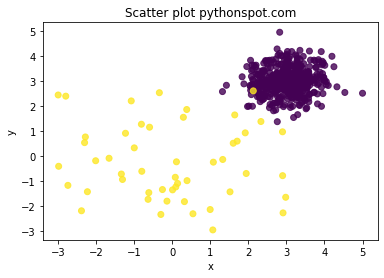

In [1]:
# Install and import the necessary modules
!pip install pyod
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

# Set the parameters and generate the data
contamination = 0.1 # fraction of outliers
n_train = 500       # number of training points
n_test  = 500       # number of testing points
n_features = 2      # number of features
random_state = 18   # random state for reproducibility
X_train, y_train, X_test, y_test = generate_data(n_train=n_train, 
                                                 n_test=n_test, 
                                                 n_features=n_features, 
                                                 contamination=contamination,
                                                 random_state=random_state)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [2]:
print(f'For {n_train} training observations and {100*contamination} % contamination, we expect {int(n_train*contamination)} outliers')
print(f'For {n_test} test observations and {100*contamination} % contamination, we expect {int(n_test*contamination)} outliers')

For 500 training observations and 10.0 % contamination, we expect 50 outliers
For 500 test observations and 10.0 % contamination, we expect 50 outliers


### Let's see if we can find these outliers consistently

### PyOD provides many classification models which you could otherwise find in scikit-learn. However, PyOD's models allow the user to see intermediate scores which indicate the model's confidence in a given point being an outlier. Moreover, the user can then use the trained model to generate these outlier scores on test data.

### Let's see this in action with PyOD's k-NN model, which by default has `n_neighbors=5` for k

### Exercise: Train PyOD's default k-NN classifier and make predictions with it

### IMPORTANT NOTE: All of the models which we'll employ in this exercise are unsupervised! While we did generate ground truth labels along with features, we'll only use them for visualization purposes and not for training the models!

In [3]:
# train kNN detector
from pyod.models.knn import KNN
from pyod.utils.utility import standardizer

def get_knn_scores_and_predictions(X_train, X_test, n_neighbors=5):
    ### START CODE HERE ###
    # Initialize the model
    clf = KNN(n_neighbors=n_neighbors)
    # Train the model
    clf.fit(X_train)
    # Get the training data's outlier/decision scores with the decision_scores_ attribute
    y_train_scores = clf.decision_scores_
    # Generate the anomaly scores for the test data using the decision_function() method 
    y_test_scores = clf.decision_function(X_test)
    # Convert the outlier scores to 2D column arrays, then standardize them so they have 
    # a mean of 0 and standard deviation of 1
    y_train_scores_norm, y_test_scores_norm = standardizer(y_train_scores.reshape(-1, 1)
                                            , standardizer(y_test_scores.reshape(-1,1)))
    # Apply the model to the test data to get predictions
    y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
    ### END CODE HERE ###
    return y_train_scores_norm, y_test_scores_norm, y_test_pred

# Call the function with the default KNN
y_train_scores_norm, y_test_scores_norm, y_test_pred = get_knn_scores_and_predictions(X_train, X_test)

### Count how many test data points are "normal" (inliers) and outliers

In [4]:
# We have a binary classification problem ("normal" points labeled 0 and outliers labeled 1)
# Let's see how many points are predicted to belong to each class
unique, counts = np.unique(y_test_pred, return_counts=True)
for label, count in dict(zip(unique, counts)).items():
    print(f'{count} points in the test data are predicted to belong to class {label}')

455 points in the test data are predicted to belong to class 0
45 points in the test data are predicted to belong to class 1


### Visualize the distribution of the standardized test data outlier scores

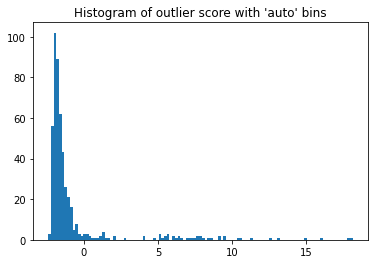

In [5]:
plt.hist(y_test_scores_norm, bins='auto') 
plt.title("Histogram of outlier score with 'auto' bins")
plt.show()

### It seems reasonable to assume that points with outlier scores below a certain threshold are assigned to Class 0 (the normal, inlier class), and those with scores above are assigned to Class 1 (the anomalous, outlier class). Where is that threshold, though? From glancing at the plot above, 0 appears to be a good threshold score. 

### Exercise: Assign test data points to inlier and outlier clusters based on the side of the threshold on which their outlier scores fall. Print the number of points assigned to each cluster and the mean value of each feature within each cluster.

In [6]:
def clustering(X_test, y_test_scores_norm, threshold):
    ### START CODE HERE ###
    # Create a new DataFrame from the test features
    df_test = pd.DataFrame(X_test)
    # Make a new column containing each point's outlier score
    df_test['score'] = y_test_scores_norm
    # Assign each point to a cluster based on the side of the threshold
    # on which its outlier score falls
    df_test['cluster'] = np.where(df_test['score'] < threshold, 0, 1)
    # Print the number of points assigned to each cluster
    print(f'Class counts:')
    print(df_test['cluster'].value_counts());
    # Display the mean values of each feature within each cluster
    print('Mean value of each feature within each cluster:')
    print(df_test.groupby('cluster').mean())
    ### END CODE HERE ###
    return df_test

# Call the function
df_test = clustering(X_test, y_test_scores_norm, threshold=0)

Class counts:
0    436
1     64
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
                0         1    score
cluster                             
0        3.036441  3.005701 -1.64207
1        0.759840  0.651659  5.75663


### Keep in mind that the horizontal labels in the figure immediately above correspond to feature names, not cluster numbers. The inliers and outliers are thus quite well separated.

### Inspect visually how our model performed

In [7]:
def get_plots(X_test, y_test, y_test_pred, df_test):
    plt.tight_layout()

    plt.subplots(1, 3, figsize = (18, 6))

    plt.subplot(1,3,1)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.8)
    plt.title('Inliers vs. Outliers: Ground Truth', )
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1,3,2)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred, alpha=0.8)
    plt.title('Inliers vs. Outliers: Automatic Predictions')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1,3,3)
    plt.scatter(df_test[0], df_test[1], c=df_test['cluster'], alpha=0.8)
    plt.title('Inliers vs. Outliers: Predictions by Threshold')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    # Dummy return
    return None

<Figure size 432x288 with 0 Axes>

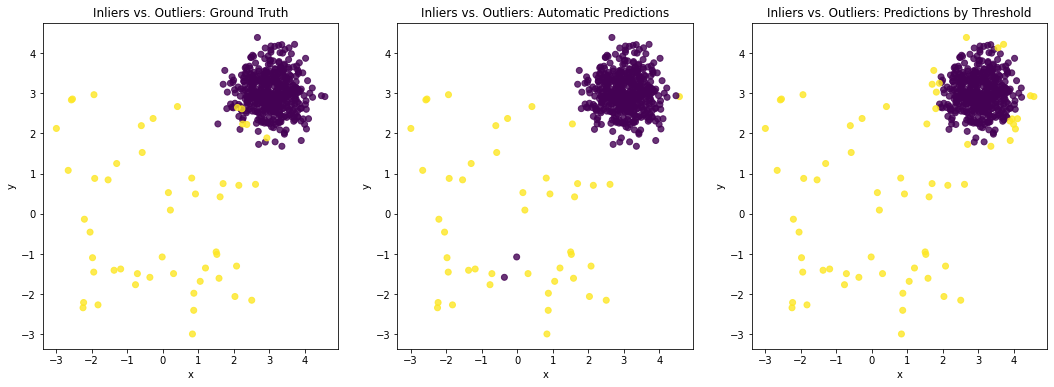

In [8]:
get_plots(X_test, y_test, y_test_pred, df_test)

### Exercise: Combine the previous exercises and visualizations into a single overarching function. Then use that function to run k-NN anomaly detection with k = 1 and k = 9.

In [9]:
def knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=5, threshold=0): 
    ### START CODE HERE ###
    # Get scores and predictions
    y_train_scores_norm, y_test_scores_norm, y_test_pred = get_knn_scores_and_predictions(X_train, X_test, n_neighbors=n_neighbors)
    # Count the number of points in the test data predicted to belong to each class
    unique, counts = np.unique(y_test_pred, return_counts=True)
    for label, count in dict(zip(unique, counts)).items():
        print(f'{count} points in the test data are predicted to belong to class {label}')
    # Visualize the distribution of outlier scores in the test data
    plt.hist(y_test_scores_norm, bins='auto') 
    plt.title("Histogram of outlier score with 'auto' bins")
    plt.show()
    # Clustering by threshold
    df_test = clustering(X_test, y_test_scores_norm, threshold=threshold)
    # Get plots
    get_plots(X_test, y_test, y_test_pred, df_test)
    ### END CODE HERE ###
    # Dummy return
    return None

463 points in the test data are predicted to belong to class 0
37 points in the test data are predicted to belong to class 1


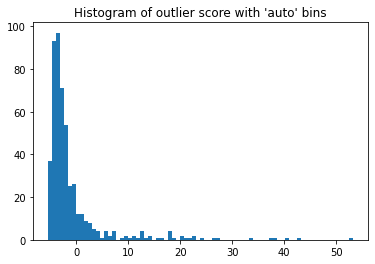

Class counts:
0    402
1     98
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        3.024400  2.992753 -3.053682
1        1.599074  1.521482  9.237159


<Figure size 432x288 with 0 Axes>

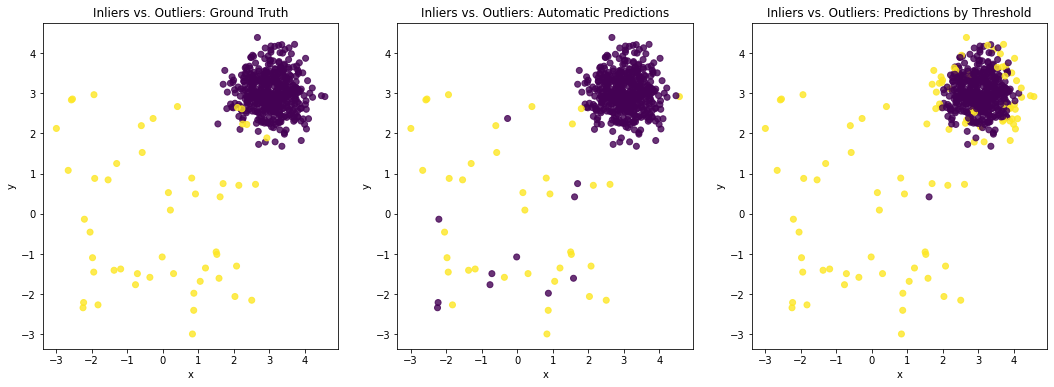

In [10]:
knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=1, threshold=0)

455 points in the test data are predicted to belong to class 0
45 points in the test data are predicted to belong to class 1


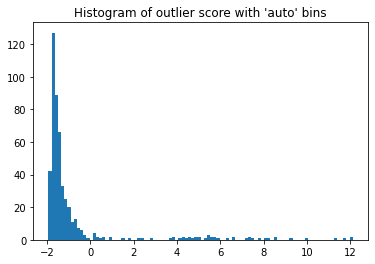

Class counts:
0    454
1     46
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        3.043534  2.998590 -1.413264
1       -0.201007 -0.199304  6.088843


<Figure size 432x288 with 0 Axes>

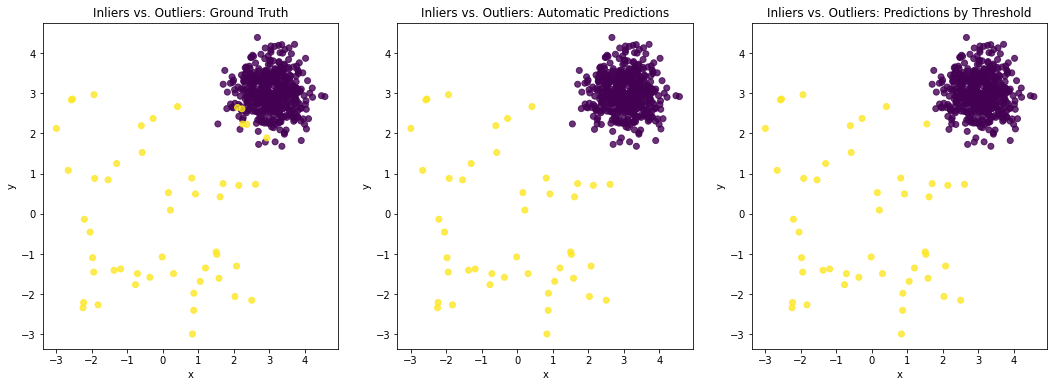

In [11]:
knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=9, threshold=1)

### Excercise: Set up a function to get PCA scores and predictions

In [12]:
from pyod.models.pca import PCA

def get_pca_scores_and_predictions(X_train, X_test, n_components=2):
    ### START CODE HERE ###
    # Initialize the model
    clf = PCA()
    # Train the model
    clf.fit(X_train)
    # Get the training data's outlier/decision scores with the decision_scores_ attribute
    y_train_scores = clf.decision_scores_
    # Generate the anomaly score using the decision_function() method
    y_test_scores = clf.decision_function(X_train)
    # Convert the outlier scores to 2D column arrays, then standardize them
    y_train_scores_norm, y_test_scores_norm = standardizer(y_train_scores.reshape((-1, 1))) , standardizer(y_test_scores.reshape((-1, 1)))
    # Apply the model to the test data to get predictions
    y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
    ### END CODE HERE ###
    return y_train_scores_norm, y_test_scores_norm, y_test_pred

### Exercise: Implement an overarching PCA anomaly detection function

In [13]:
def pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=0):
    ### START CODE HERE ###
    # Get scores and predictions
    y_train_scores_norm, y_test_scores_norm, y_test_pred = get_pca_scores_and_predictions(X_train, X_test, n_components=n_components)
    # Count the number of points in the test data predicted to belong to each class
    unique, counts = np.unique(y_test_pred, return_counts=True)
    for label, count in dict(zip(unique, counts)).items():
        print(f'{count} points in the test data are predicted to belong to class {label}')
    # Visualize the distribution of outlier scores in the test data
    plt.hist(y_test_scores_norm, bins='auto') 
    plt.title("Histogram of outlier score with 'auto' bins")
    plt.show()
    # Clustering by threshold
    df_test = clustering(X_test, y_test_scores_norm, threshold=threshold)
    # Get plots
    get_plots(X_test, y_test, y_test_pred, df_test)
    ### END CODE HERE ###
    # Dummy return
    return None

### Run the PCA anomaly detection function with 2 components and the default outlier score threshold

447 points in the test data are predicted to belong to class 0
53 points in the test data are predicted to belong to class 1


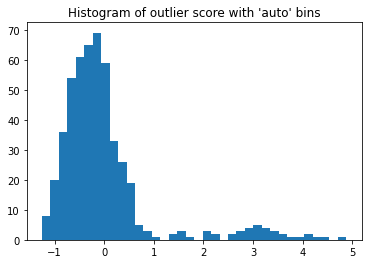

Class counts:
0    339
1    161
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        3.027187  2.988565 -0.456299
1        2.150940  2.106015  0.960779


<Figure size 432x288 with 0 Axes>

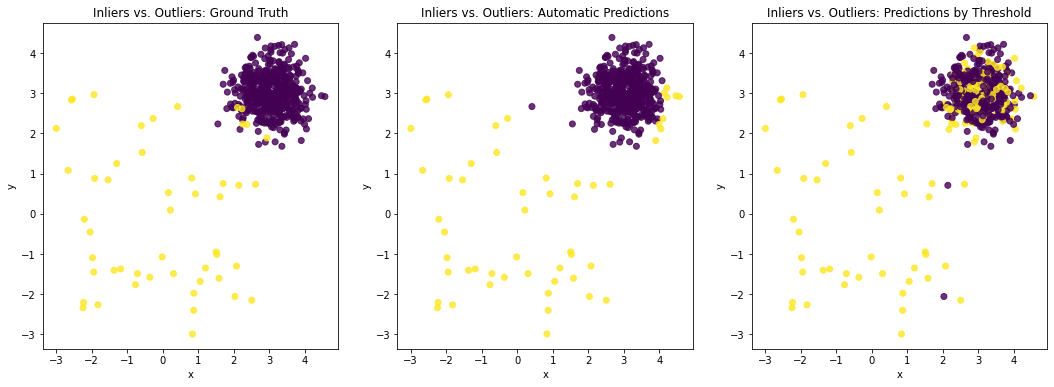

In [14]:
pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=0)

### Hmm, PCA didn't distribute the anomaly scores nearly as tightly as k-NN did. Moreover, the right tail of the anomaly scores' distribution appears to begin around 1. Let's rerun our PCA anomaly detection function with 1 as our threshold instead.

447 points in the test data are predicted to belong to class 0
53 points in the test data are predicted to belong to class 1


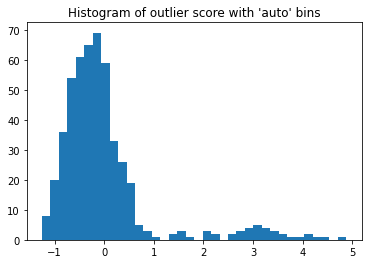

Class counts:
0    458
1     42
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        2.978417  2.947722 -0.265623
1        0.200073  0.050840  2.896554


<Figure size 432x288 with 0 Axes>

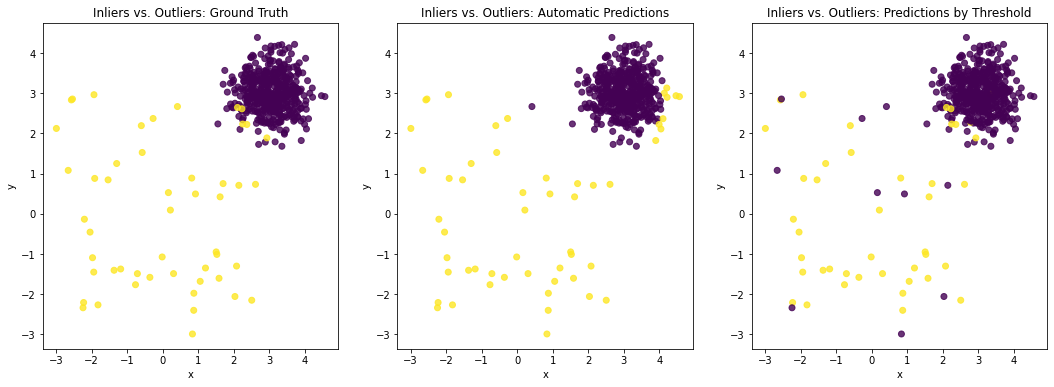

In [15]:
pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=1)